In [2]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("Data Clean")\
    .getOrCreate()

# dirtyData.select('cleaned_body').show()

In [5]:
# CUSTOM TRANSFORMER ----------------------------------------------------------------
class TextCleaner(Transformer):
    """
    A custom Transformer which drops all columns that have at least one of the
    words from the banned_list in the name.
    """

    def __init__(self, inputCol='body', outputCol='cleaned_body'):
        super(TextCleaner, self).__init__()
#         self.banned_list = banned_list
    def clean(line):
        print(line)
        line = line.lower().replace("\n"," ").replace("\r","").replace(',',"").replace(">","> ").replace("<", " <")
        return line
    clean_udf = udf(lambda r: clean(r), StringType())

    def _transform(self, df: DataFrame) -> DataFrame:
        df = df.withColumn('cleaned_body', clean_udf(df['body']))
        df = df.drop('body')
    #         df = df.drop(*[x for x in df.columns if any(y in x for y in self.banned_list)])
        return df

In [10]:
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, IDFModel
from pyspark.sql import DataFrame
from numba import jit

@jit
def clean(line):
    # connect to redis
    # r.set()
    line = line.lower().replace("\n"," ").replace("\r","").replace(',',"").replace(">","> ").replace("<", " <")
    return line

clean_udf = udf(lambda r: clean(r), StringType())

dirtyData = spark.read.csv("sDirtyc.csv.gz", header=True, multiLine=True, escape='"')

# cleaner = TextCleaner(inputCol='body', outputCol='cleaned_body')
# dirtyData = cleaner.transform(dirtyData)
dirtyData = dirtyData.withColumn('cleaned_body', clean_udf(dirtyData['body']))

# partialData = dirtyData.limit(10)

tokenizer = Tokenizer(inputCol="cleaned_body", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=2**16)
idf = IDF(inputCol="rawFeatures", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])

# Fit the pipeline to training documents.
model = pipeline.fit(dirtyData)
# print(dir(model))
# model.save('model')

# model.fit(partialData)
# model.save('model2')



dirtyData = model.transform(dirtyData)

# modelPath = "temp/idf-model"
# model.save(modelPath)
# loadedModel = IDFModel.load(modelPath)
# sample = loadedModel.transform(featurizedData)

# data = spark.read.format("parquet").load("test2.parquet")

In [105]:
d = dirtyData.select('features').collect()

In [106]:
%timeit d[0]['features'].dot(d[1]['features'])

57.3 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [108]:
def extract(vector):
    return (vector.size, vector.indices, vector.values)

%timeit extract(d[0]['features'])

1.75 µs ± 87.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [111]:
from pyspark.ml.linalg import SparseVector
def assemble(size, inds, vals):
    return SparseVector(size, inds, vals)
s,i,v = extract(d[0]['features'])
%timeit assemble(s,i,v)

111 µs ± 4.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [112]:
print(d[0]['features'].dot(d[1]['features']))

49.31364472427597


In [138]:
s,i,v = extract(d[0]['features'])
d2,i2,v2 = extract(d[1]['features'])

In [178]:
def cos(s1,i1,v1,b):
    a = SparseVector(s1,i1,v1)
    if a is None:
        return 0.0
    return float(a.dot(b)/(a.norm(2)*b.norm(2)))
%timeit cos(s,i,v,d[1]['features'])

227 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [179]:
print(cos(s,i,v,d[1]['features']))

0.03240739425923077


In [176]:
# %load_ext Cython
# print(list(v), list(v2))

[7.843946672562629, 1.9070703157390494, 1.7819071727850435, 1.670681537674819, 7.033016456346299, 3.005682604407159, 3.4494975178901894, 1.3192836508369303, 9.686478467164108, 2.5658320133321113, 2.9592526018242196, 3.9219733362813143, 7.843946672562629, 3.5165082281731497, 3.9219733362813143, 3.5165082281731497, 2.0632031567702986, 2.6692103677859462, 0.20308930149369256, 3.9219733362813143, 6.457652311442738, 2.6692103677859462, 3.515487557065567, 3.9219733362813143, 3.9219733362813143, 2.41789593950504, 0.9813995452233077, 2.0501711593797225, 3.5165082281731497, 1.2155746632175772, 2.130213867053259, 3.5165082281731497, 2.217225244042889, 3.9219733362813143, 3.9219733362813143, 3.9219733362813143, 2.41789593950504, 7.843946672562629, 3.5165082281731497, 3.4494975178901894, 2.5356789751614235, 2.8233610476132043, 0.5375830729355401, 1.5705980791178364, 3.9219733362813143, 3.9219733362813143, 3.228826155721369, 0.0, 0.08252102368800344, 1.5705980791178364, 2.8233610476132043, 3.921973

In [ ]:
def intersect(a,b):
    l = max(len(a),len(b))
    inds = []
    for i in range(l):
        
print(intersect(i,i2))

In [428]:
# takes ~150us per comparison, but only 1us to extract values
from numba import jit
from numpy.linalg import norm

@jit
def cos(inds1, vals1, inds2, vals2):
#     inds1 = np.array(inds1)
#     inds2 = np.array(inds2)
    product = 0.0
    count = 0
    for count1 in range(len(inds1)):
        for count2 in range(len(inds2)):
            if inds1[count1] == inds2[count2]:
                product += vals1[count1]*vals2[count2]
    product /= norm(vals1, ord=2)*norm(vals2, ord=2)
    return product

%timeit cos(i,v,i2,v2)
# print(np.intersect1d(i,i2))
# print(i)
    

16.3 µs ± 4.79 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
print(type(v3[0]))
%timeit v3.astype(np.float64)
# print(np.isin(i,i2))

<class 'numpy.float16'>
2 µs ± 365 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [420]:
def cos_np(inds1,vals1,inds2,vals2):
    i1 = np.where(np.isin(inds1,inds2))
    i2 = np.where(np.isin(inds2,inds1))
    product = np.sum(vals1[i1]*vals2[i2])
    return product #/np.linalg.norm(vals1)/np.linalg.norm(vals2)
#     i1 = np.where(inds1==inds2)
# %timeit cos_np(i,v,i2,v2)
cos_np(i3,v3,i2,v2)

49.31511158899758

In [343]:
%%cython -a
from numpy cimport ndarray as ar
import cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef norm(const double [:] a):
    cdef int k = 0
    cdef double val = 2.0
    cdef double n
    for i in range(len(a)):
        k = i
        n = n+a[k]**val
    return n**0.5

@cython.boundscheck(False)
@cython.wraparound(False)
def dot(const int [:] inds1, const double [:] vals1, const int [:] inds2,const double [:] vals2):
    cdef double product = 0
    cdef int k = 0
    cdef int j = 0
    for count1 in range(len(inds1)):
        for count2 in range(len(inds2)):
            k = count1
            j = count2
            if inds1[k] == inds2[j]:
                product += vals1[k]*vals2[j]
    product /= norm(vals1)*norm(vals2)
    return product


In [488]:
%%cython -a
#from numpy cimport ndarray as ar
#cimport numpy as np
import cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef norm2(const double [:] a):
    cdef int k = 0
    cdef double val = 2.0
    cdef double n = 0
    for i in range(len(a)):
        k = i
        n += a[k]**val
    return n**0.5

@cython.boundscheck(False)
@cython.wraparound(False)
cdef common_inds(const int [:] a,const int [:] b, int [:,::] c):
    cdef int count = 0
#     print(len(a), len(b))
    cdef int n = len(b)
    cdef int m = len(a)
    cdef int i = 0
    cdef int total = 0
    cdef int k = 0
    for k in range(10*m):
        if a[i] == b[count]:
            c[total,0] = i
            c[total,1] = count
            count += 1
            total += 1
#             inds.append([i,count])
        elif a[i] > b[count]:
            i -= 1
            count += 1
        if count >= n:
            break
        i += 1
#         total += 1
    return total

@cython.boundscheck(False)
@cython.wraparound(False)
def cos(const int [:] inds1,const double [:] vals1,const int [:] inds2,const double [:] vals2, int [:,::] data_store):
    cdef double product = 0
    cdef int n = len(inds1)
    cdef int m = len(inds2)
    cdef int count = 0
    cdef int i = 0
    if n > m:
        count = common_inds(inds1, inds2, data_store)
        for i in range(count):
            product += vals1[data_store[i,0]]*vals2[data_store[i,1]]
    else:
        count = common_inds(inds2, inds1, data_store)
        for i in range(count):
            product += vals2[data_store[i,0]]*vals1[data_store[i,1]]
    product /= (norm2(vals1)*norm2(vals2))
    return product

In [426]:
%%cython -a

cdef common_inds(int [:] a, int [:] b, double [:,::] c):
    cdef int count = 0
#     print(len(a), len(b))
    cdef int n = len(b)-1
    cdef int m = len(a)
    cdef int total = 0
    for i in range(m):
#         print(a[i], b[count])
        if a[i] == b[count]:
            count += 1
            c[count,0] = a[i]
            c[count,1] = b[count]
#             inds.append([i,count])
        elif a[i] > b[count]:
            i -= 1
            count += 1
        elif b[count] > a[i]:
            i = count
        elif count >= n:
            break
        total += 1
    return total


In [262]:
c = np.zeros((67,2))
i3 = i3.astype(np.int32)
%timeit common_inds(i3,i2,c)

7.92 µs ± 107 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [408]:
a = np.zeros((200,2),dtype=np.int32)
v3 = v3.astype(np.float64)
%timeit dot(i3,v3,i2,v2,a)
# print(dot(i3,v3,i2,v2,a))
# print(a)

5.8 µs ± 52.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [235]:
print(i3, i2)

[   53  1706  2041  2071  2464  2570  2647  2848  4200  4427  4488  5083
  5418  6393  6918  7818  8026  8323  8436  8813  9514  9572  9639 10510
 10583 15445 15889 16064 16075 16332 16417 16533 16693 16813 17539 17764
 17977 18471 19021 19208 20424 20464 20639 20818 21621 21960 22659 24354
 24417 24439 24755 24984 25178 25845 26803 27057 27213 29515 29663 29665
 29945 30110 30802 31635 32110 32294 32617 32914 33810 34200 34343 34359
 34722 35570 35633 35785 35807 36050 36080 37270 37775 37852 38302 38798
 40329 40571 40780 40872 41153 41288 41502 41704 41861 42389 43770 43829
 44469 44889 45892 46467 46825 46967 47707 47896 48007 48228 48448 49463
 49770 50430 50432 50499 50654 50940 51052 52572 52633 52853 53048 53054
 54937 55242 55720 56344 56562 56747 57389 57885 58134 58236 58611 59836
 60255 61318 62794 64356 65426] [  652   732  2848  2899  4488  7595  8436  9888 10020 11650 11757 12525
 15445 15889 16030 16332 19280 19592 20785 22877 24354 24414 24417 24439
 25308 25845 26888 

In [ ]:
# demo script
Hello everyone, my name is Neal Dawson-Elli, and my project is CloudCompare: 
    A tool for comparing text at cloud scale using the Stack Overflow dataset.

I'm sure everyone here has used Stack Overflow before, it's one of the best resources
there are for technical questions.  In fact, every day, 4000 questions are asked of
the volunteer experts at Stack Overflow.  Ultimately, ~160 of these questions will
be marked a duplicate, which is a very work-intensive process: experts must
    * find the original post and link it
    * have 4 other experts agree the posts are sufficiently related
    
This model doesn't scale well - as the question repository grows, the number
of duplicates will also grow, and the effort required to find the duplicate posts will
increase.  The opportunity cost of these duplicates is unanswered questions - of the
17 million questions, <> remain unanswered.

However, doing text comparisons at cloud scale is hard - string comparison is expensive,
raw text is large in memory, and distributing large files takes time, which means that this should
ideally be a streaming service.

The approach I took is as follows:
    * CSVs were loaded into S3 and processed in a spark job which fit a TF-IDF model on the data.
        This is advantageous because sparse vectors are much easier to compare than text.
    * These processed files are loaded into a Redis database, which is accessed by a Spark Streaming service
        and takes jobs from a Kafka node, which communicates with a simple Dash frontend.



In [498]:
def common_inds(a,b):
    inds = []
    count = 0
#     print(len(a), len(b))
    n = len(b)
#     print(n)
    m = len(a)
    total = 0
    i = 0
#     while i < m:
    for k in range(2*m):
#         print('i:', i, 'count:', count, a[i], b[count])
        total += 1
#         print(a[i], b[count])
        if a[i] == b[count]:
            inds.append([i,count])
            count += 1
        elif a[i] > b[count]:
            i -= 1
            count += 1
        if count >= n:
            break
        i += 1
    return inds, total, m*n

def cos_np(inds1,vals1,inds2,vals2):
    i1 = np.where(np.isin(inds1,inds2))
    i2 = np.where(np.isin(inds2,inds1))
    product = np.sum(vals1[i1]*vals2[i2])
    return product/np.linalg.norm(vals1)/np.linalg.norm(vals2)

a = np.arange(0,40).astype(np.int32)
b = np.arange(5,70).astype(np.int32)
c = np.arange(0,40).astype(np.float64)
d = np.arange(5,70).astype(np.float64)

sv1 = SparseVector(150,a,c)
sv2 = SparseVector(150,b,d)
print(sv1.dot(sv2)/(sv1.norm(2)*sv2.norm(2)))
print(sv2.norm(2))
# print(norm4(d))
cos(a,c,b,d,np.zeros((200,2),dtype=np.int32))
# print(cos_np(a,c,b,d))
# # print(cos(a,c,b,d))
# # print(sv2.norm(2))
# # print(norm(d))
# temp = np.array(common_inds(b,a)[0])
# i1 = np.where(np.isin(a,b))
# i2 = np.where(np.isin(b,a))
# # print(temp)
# # print(i1-temp[:,1], i2-temp[:,0])
# # print(np.sum(c[i1]*d[i2]))
# print(c[temp[:,1]]*d[temp[:,0]])
# print(len(i3), len(i2))

0.4278763941916053
334.46225497057213


0.4278763941916053

In [499]:
dd = np.zeros((1000,2),dtype=np.int32)
for i in range(2,400):
    for j in range(2,150):
        a = np.arange(0,i).astype(np.int32)
        b = np.arange(0,j).astype(np.int32)
        c = np.arange(0,i).astype(np.float64)
        d = np.arange(0,j).astype(np.float64)
        f = cos(a,c,b,d,dd)
#         print(f)

In [371]:
def ci2(a,b):
    inds = []
    for count1, i in enumerate(a):
        for count2, j in enumerate(b):
            if i == j:
                inds.append([count1, count2])
    return inds
ci2(i3,i2)

[[7, 2],
 [10, 4],
 [18, 6],
 [25, 12],
 [26, 13],
 [29, 15],
 [47, 20],
 [48, 22],
 [49, 23],
 [53, 25],
 [59, 27],
 [62, 29],
 [71, 32],
 [74, 34],
 [81, 38],
 [82, 39],
 [96, 44],
 [102, 48],
 [106, 49],
 [115, 55],
 [121, 56]]

In [528]:
a = zlib.compress(sample.indices.tobytes())
b = zlib.compress(sample.values.astype('float16').tobytes())
print(sys.getsizeof(sample.values.astype('float16')))
print(sys.getsizeof(zlib.compress(sample.indices)))
i3 = np.frombuffer(zlib.decompress(a),dtype='int32')
v3 = np.frombuffer(zlib.decompress(b), dtype='float16')
print(i3, v3)
# i3 = np.frombuffer(sample.indices.tobytes())
# v3 = np.frombuffer(sample.values.astype('float16').tobytes())

370
436
[   53  1706  2041  2071  2464  2570  2647  2848  4200  4427  4488  5083
  5418  6393  6918  7818  8026  8323  8436  8813  9514  9572  9639 10510
 10583 15445 15889 16064 16075 16332 16417 16533 16693 16813 17539 17764
 17977 18471 19021 19208 20424 20464 20639 20818 21621 21960 22659 24354
 24417 24439 24755 24984 25178 25845 26803 27057 27213 29515 29663 29665
 29945 30110 30802 31635 32110 32294 32617 32914 33810 34200 34343 34359
 34722 35570 35633 35785 35807 36050 36080 37270 37775 37852 38302 38798
 40329 40571 40780 40872 41153 41288 41502 41704 41861 42389 43770 43829
 44469 44889 45892 46467 46825 46967 47707 47896 48007 48228 48448 49463
 49770 50430 50432 50499 50654 50940 51052 52572 52633 52853 53048 53054
 54937 55242 55720 56344 56562 56747 57389 57885 58134 58236 58611 59836
 60255 61318 62794 64356 65426] [ 7.844   1.907   1.782   1.671   7.03    3.006   3.45    1.319   9.69
  2.566   2.959   3.922   7.844   3.516   3.922   3.516   2.062   2.67
  0.2031  3.922

ValueError: buffer source array is read-only

In [56]:
import gzip
d = dirtyData.select('features').collect()
print(sys.getsizeof(d[0]['features']))
print(sys.getsizeof(str(d[0]['features'])))
print(sys.getsizeof(gzip.compress(str(d[0]['features']).encode())))

56
3381
1109


In [332]:
# a = np.random.rand(200)
# a = np.frombuffer(a, dtype=np.float16)
# print(a)
# %timeit np.array(a)

In [305]:
a = gzip.compress(str(d[0]['features'].values).encode())
a = gzip.decompress(a)

In [339]:
print(d[0]['features'].dot(d[1]['features'])/(d[0]['features'].norm(2)*d[1]['features'].norm(2)))
print(d[0]['features'].norm(2))
print(d[1]['features'].norm(2))

0.03240739425923077
43.982219723132765
34.59758982176152


In [341]:
i = np.array(d[0]['features'].indices)
v = np.array(d[0]['features'].values)
i2 = np.array(d[1]['features'].indices)
v2 = np.array(d[1]['features'].values)
print(dot(i,v,i2,v2))
# print(norm(a))


0.032407394259230754


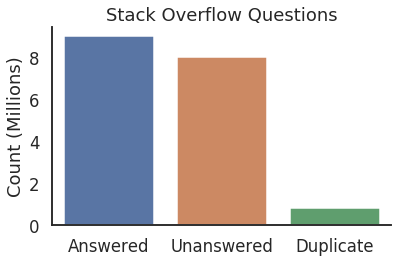

In [662]:
import seaborn as sns
sns.set(style="white", context="talk")

y = [17-8, 8, 0.8]
x = [0,1,2]
xlabels = ['Answered','Unanswered','Duplicate']
#plt.bar(x,y)
sns.barplot(x=x, y=y, palette="deep")
plt.ylabel("Count (Millions)")
plt.title("Stack Overflow Questions")
plt.xticks([0,1,2], xlabels)
sns.despine(bottom=False)
# plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.tight_layout()
plt.savefig('SOQ.png', dpi=600)

In [ ]:
import seaborn as sns
sns.set(style="white", context="talk")

# old_sv_12 = [2.2, 1.9, 8, 108, 214, ] # time in seconds, 35 ops / second
# old_sv_24 = [2.2, 1.9, 7, 90, 162, 263] # time in seconds, 45k ops / s
old_sv_48 = [2.2, 1.9, 8, 70, 155, 225 ] # time in seconds, 
x = [0,1
y = [25,45,60,50,75,75,240]
xlabels = ['Original','Optimized']
#plt.bar(x,y)
# sns.barplot(x=x, y=old_sv_12, palette="deep")
# sns.barplot(x=x, y=old_sv_24, palette="deep")
plt.figure(figsize=(12,5))
# sns.barplot(x=x, y=old_sv_48, palette="rocket")
# time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
# time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
sns.barplot(x=x, y=y, palette="Blues_r")
plt.ylabel("Thousand Ops/s")
plt.title("Redis Ops/s")
plt.xticks(x, xlabels)
sns.despine(bottom=False)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

AttributeError: 'float' object has no attribute 'axes'

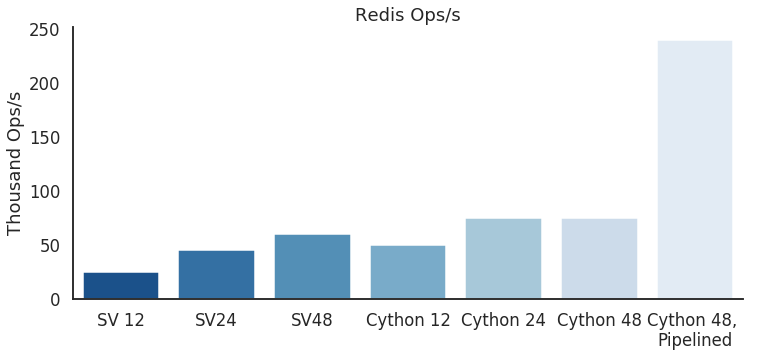

In [550]:
import seaborn as sns
sns.set(style="white", context="talk")

# old_sv_12 = [2.2, 1.9, 8, 108, 214, ] # time in seconds, 35 ops / second
# old_sv_24 = [2.2, 1.9, 7, 90, 162, 263] # time in seconds, 45k ops / s
old_sv_48 = [2.2, 1.9, 8, 70, 155, 225 ] # time in seconds, 
x = [0,1,2,3,4,5,6]
y = [25,45,60,50,75,75,240]
xlabels = ['SV 12','SV24','SV48','Cython 12','Cython 24','Cython 48','Cython 48, \nPipelined']
#plt.bar(x,y)
# sns.barplot(x=x, y=old_sv_12, palette="deep")
# sns.barplot(x=x, y=old_sv_24, palette="deep")
plt.figure(figsize=(12,5))
# sns.barplot(x=x, y=old_sv_48, palette="rocket")
# time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
# time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
sns.barplot(x=x, y=y, palette="Blues_r")
plt.ylabel("Thousand Ops/s")
plt.title("Redis Ops/s")
plt.xticks(x, xlabels)
sns.despine(bottom=False)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [663]:
import random
# random.randint(0,100)

34

AttributeError: 'float' object has no attribute 'axes'

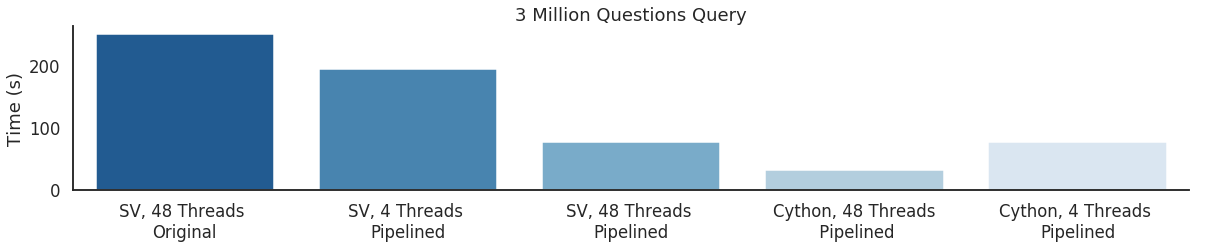

In [576]:
import seaborn as sns
sns.set(style="white", context="talk")

# old_sv_12 = [2.2, 1.9, 8, 108, 214, ] # time in seconds, 35 ops / second
# old_sv_24 = [2.2, 1.9, 7, 90, 162, 263] # time in seconds, 45k ops / s
# old_sv_48 = [2.2, 1.9, 8, 70, 155, 225 ] # time in seconds, 
x = [0,1,2,3,4] #,5] #,6]
y = [250, 194, 76, 32, 76] #, 70, ]
xlabels = ['SV, 48 Threads \nOriginal','SV, 4 Threads \nPipelined','SV, 48 Threads \nPipelined','Cython, 48 Threads\n Pipelined', 'Cython, 4 Threads \nPipelined',
          ] #'Cython, 6 Threads \n (t2.medium)','SV, 6 Threads \n (t2.medium)']
#plt.bar(x,y)
# sns.barplot(x=x, y=old_sv_12, palette="deep")
# sns.barplot(x=x, y=old_sv_24, palette="deep")
plt.figure(figsize=(20,3))
# sns.barplot(x=x, y=old_sv_48, palette="rocket")
# time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
# time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
sns.barplot(x=x, y=y, palette="Blues_r")
plt.ylabel("Time (s)")
plt.title("3 Million Questions Query")
plt.xticks(x, xlabels)
sns.despine(bottom=False)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

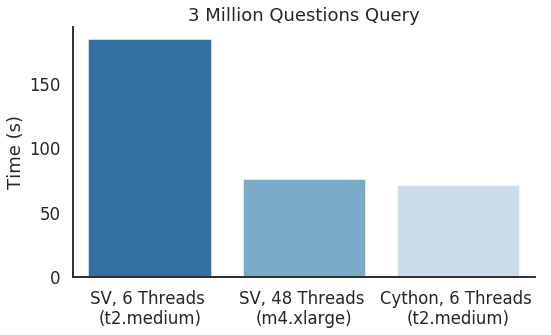

In [579]:
import seaborn as sns
sns.set(style="white", context="talk")

# old_sv_12 = [2.2, 1.9, 8, 108, 214, ] # time in seconds, 35 ops / second
# old_sv_24 = [2.2, 1.9, 7, 90, 162, 263] # time in seconds, 45k ops / s
# old_sv_48 = [2.2, 1., 8, 70, 155, 225 ] # time in seconds, 
x = [0,1,2] #,5] #,6]
y = [185, 76, 71] #, 70, ]
xlabels = ['SV, 6 Threads \n(t2.medium)','SV, 48 Threads \n(m4.xlarge)', 'Cython, 6 Threads \n(t2.medium)',
          ] #'Cython, 6 Threads \n (t2.medium)','SV, 6 Threads \n (t2.medium)']
#plt.bar(x,y)
# sns.barplot(x=x, y=old_sv_12, palette="deep")
# sns.barplot(x=x, y=old_sv_24, palette="deep")
plt.figure(figsize=(8,5))
# sns.barplot(x=x, y=old_sv_48, palette="rocket")
# time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
# time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
sns.barplot(x=x, y=y, palette="Blues_r")
plt.ylabel("Time (s)")
plt.title("3 Million Questions Query")
plt.xticks(x, xlabels)
sns.despine(bottom=False)
# plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

AttributeError: 'float' object has no attribute 'axes'

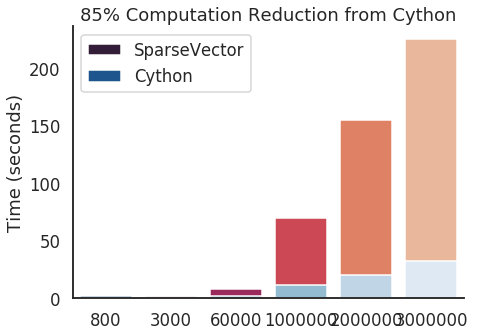

In [567]:
import seaborn as sns
sns.set(style="white", context="talk")

# old_sv_12 = [2.2, 1.9, 8, 108, 214, ] # time in seconds, 35 ops / second
# old_sv_24 = [2.2, 1.9, 7, 90, 162, 263] # time in seconds, 45k ops / s
old_sv_48 = [2.2, 1.9, 8, 70, 155, 225 ] # time in seconds, 
x = [800, 3000, 60000, 1000000, 2000000, 3000000]
# xlabels = ['1e3','1e4','6e5', '1e6','2e6','3e6']
#plt.bar(x,y)
# sns.barplot(x=x, y=old_sv_12, palette="deep")
# sns.barplot(x=x, y=old_sv_24, palette="deep")
plt.figure(figsize=(7,5))
sns.barplot(x=x, y=old_sv_48, palette="rocket", label='SparseVector')
# time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
sns.barplot(x=x, y=time_cy_48, palette="Blues_r", label='Cython')
plt.legend()
plt.ylabel("Time (seconds)")
plt.title("85% Computation Reduction from Cython")
# plt.yscale('log')
# plt.xticks(x, xlabels)
sns.despine(bottom=False)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

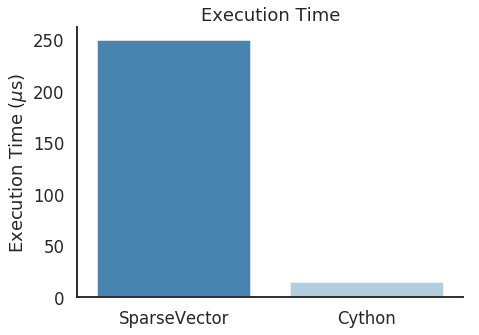

In [556]:
old_sv_48 = [2.2, 1.9, 8, 70, 155, 225 ] # time in seconds,
y = [250, 15]
x = [0,1]
xlabels = ['SparseVector','Cython']
#plt.bar(x,y)
# sns.barplot(x=x, y=old_sv_12, palette="deep")
# sns.barplot(x=x, y=old_sv_24, palette="deep")
plt.figure(figsize=(7,5))
# sns.barplot(x=x, y=old_sv_48, palette="rocket")
# time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
# time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
sns.barplot(x=x, y=y, palette="Blues_r")
plt.ylabel("Execution Time ($\mu $s)")
plt.title("Execution Time")
plt.xticks(x, xlabels)
sns.despine(bottom=False)
# plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

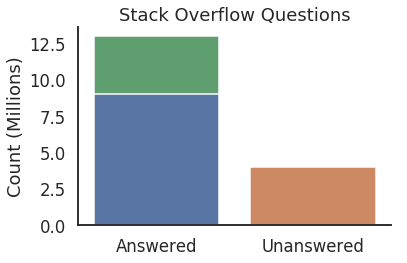

In [660]:
import seaborn as sns
sns.set(style="white", context="talk")
unans = 8
unans = unans-(5*0.8)
y = [9, unans]
x = [0,1]
# x1 = [0]
xlabels = ['Answered','Unanswered']
#plt.bar(x,y)
# sns.barplot(x=[0], y=[9])
# plt.figure(figsize=(10,7))
sns.barplot(x=[0], y=[17-unans], color=sns.color_palette('deep')[2])
sns.barplot(x=x, y=y, palette="deep")


plt.ylabel("Count (Millions)")
plt.title("Stack Overflow Questions")
plt.xticks([0,1], xlabels)
sns.despine(bottom=False)
plt.tight_layout(h_pad=2)
plt.tight_layout()
plt.savefig('SOQ-update.png', dpi=600)

In [559]:
print([(x-y)/x for x, y in zip(old_sv_48, time_cy_48)])

[0.27272727272727276, 0.47368421052631576, 0.7875, 0.8357142857142857, 0.8709677419354839, 0.8577777777777778]


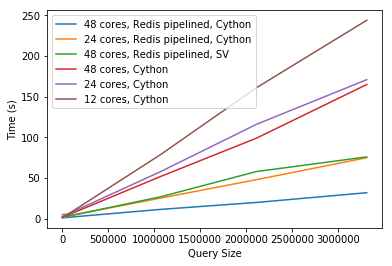

In [348]:
filter_size = [784, 2864, 60446, 1070051, 2110199, 3310520] # filter size in points
old_sv_12 = [2.2, 1.9, 8, 108, 214, 341] # time in seconds, 35 ops / second
old_sv_24 = [2.2, 1.9, 7, 90, 162, 263] # time in seconds, 45k ops / s
old_sv_48 = [2.2, 1.9, 6, 89, 157, 244] # time in seconds, 45k ops / s

time_48 = [2, 2.5, 4.5, 52, 99, 165] # time in seconds, ~82k ops/s
time_24 = [4.8, 5.1, 5.8, 58, 116, 171] # time in seconds, ~75k ops/s
time_12 = [1.5, 1.5, 5.5, 79, 161, 244] 

time_sv_48 = [2.5, 2.5, 3.1, 27, 58, 76] # ~100k ops/s, have seen 300k with no calc
time_cy_48 = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
time_cy_24 = [1.4, 1.0, 3.3, 25.4, 48, 75] # ~90k ops/s
time_cy_48_n = [1.6, 1.0, 1.7, 11.5, 20, 32] # ~240k ops/s
time_cy_4 = [1.7, 1.7, 2.5, 32, 50, 76] # ~110k ops/s 
time_cy_2 = [1.7, 1.7, 3.0, 47, 80, 123]
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.plot(filter_size, time_cy_48, label = '48 cores, Redis pipelined, Cython')
plt.plot(filter_size, time_cy_24, label = '24 cores, Redis pipelined, Cython')
plt.plot(filter_size, time_sv_48, label = '48 cores, Redis pipelined, SV')
plt.plot(filter_size, time_48, label = '48 cores, Cython')
plt.plot(filter_size, time_24, label = '24 cores, Cython')
plt.plot(filter_size, time_12, label = '12 cores, Cython')
plt.ylabel('Time (s)')
plt.xlabel('Query Size')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [643]:
from lxml import html
import requests
# web = request('https://stackoverflow.com/questions/32022334/can-apache-spark-run-without-hadoop')
# page = requests.get('https://stackoverflow.com/questions/32022334/can-apache-spark-run-without-hadoop')
page = requests.get('https://stackoverflow.com/questions/240178/list-of-lists-changes-reflected-across-sublists-unexpectedly')
tree = html.fromstring(page.content)
# print(dir(tree))
# //*[@id="question-header"]/h1/a
# //*[@id="question"]/div[2]/div[2]/div[1]
title = tree.xpath('//*[@id="question-header"]/h1/a/text()')[0]
post = tree.xpath('//*[@id="question"]/div[2]/div[2]/div[1]')[0]
            tags = tree.xpath('//*[@id="question"]/div[2]/div[2]/div[2]/div')
            # print(tags)
            dirty_tags = tags[0].text_content().split(' ')
            clean_tags = []
            for t in dirty_tags:
                if t in ['','\r\n']:
                    continue
                else:
                    clean_tags.append(t)
print(clean_tags)
# dir(tags[0].text)
# print(title)
# post.getchildren
# print(post.text_content())
# dir(post)
# [list(p) for p in post]
# post = post.getchildren().ipynb_checkpoints/
# print(post.getchildren())

['python', 'list', 'nested-lists', 'mutable']


In [522]:
t = """<p>I am getting unexpected results when adding items to sets that are in a list such that i can specify the set i need by indexing the list as shown in the following code:</p>

<pre><code>def get_friends_of_users(network):
    f1 = lambda x: x[0]
    f2 = lambda x: x[1]
    users_friends = [set()] * max(max(network, key=f1)[0], max(network, key=f2)[1]+1)
    net_users = set()
    for i in network:
        users_friends[i[0]].add(i[1])
        users_friends[i[1]].add(i[0])
        net_users.add(i[0])
        net_users.add(i[1])
        #print(users_friends)
    return net_users, users_friends
</code></pre>

<p>let the variable network be the following list of tuples:</p>

<p><code>network = [(3, 5), (2, 1), (2, 4), (1, 5), (5, 0), (3, 2), (3, 0)]</code>
which describes users and their friends as (user_ID, friend_ID).</p>

<p>I want the variable <code>users_friends</code> to be a list of sets of all friends for each user as following:</p>

<p>User ID=0 has friends with IDs = 3, 5 </p>

<p>User ID=1 has friends with IDs = 2, 5 </p>

<p>User ID=2 has friends with IDs = 1, 3, 4 </p>

<p>User ID=3 has friends with IDs = 0, 2, 5 </p>

<p>User ID=4 has friends with IDs = 2 </p>

<p>User ID=5 has friends with IDs = 0, 1, 3.</p>

<p>But when i uncomment the print statement in the code i can see that every time i execute the statement <code>users_friends[i[0]].add(i[1])</code> or <code>users_friends[i[1]].add(i[0])</code> it adds the item to all sets in the list.</p>

<p>so, this was the output:</p>

<pre><code>[{3, 5}, {3, 5}, {3, 5}, {3, 5}, {3, 5}, {3, 5}]

[{1, 2, 3, 5}, {1, 2, 3, 5}, {1, 2, 3, 5}, {1, 2, 3, 5}, {1, 2, 3, 5}, {1, 2, 3, 5}]

[{1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}]

[{1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}, {1, 2, 3, 4, 5}]

[{0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}]

[{0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}]

[{0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5}]
</code></pre>

<p><strong><em>My question is: why it adds the item to all sets in the list and how to make it add to the set that i specify by indexing the list of those sets?</em></strong></p>

"""
sys.getsizeof(t.encode())


2463

In [299]:
# a = ['id:'+str(i) for i in range(100,355)]
# # print(a)
# b = [','.join(a[i:i+10]) for i in range(0,255,10)]
# print(b)
a = [(np.random.rand(1)[0], 'blahblah') for i in range(250)]

print(max(a))
# time to sort an array: vs time:
# 300 -> 150 us, 500 -> 230 us, 1000 -> 500us
# %timeit max(a)
# b = np.random.rand(1)
# print(b[0])


(0.9993411729845811, 'blahblah')


In [68]:
# import msgpack
# import json
import struct
import binascii
value = 5.1
ba = bytearray(struct.pack("f", value)) .hex() 
binascii.hexlify(struct.pack("f", value))
print(ba)
# print([ "0x%02x" % b for b in ba ])
# json.dumps(d[0]['features'])
# msgpack.dump(d[0]['features'])

3333a340


In [80]:
import zlib
sample = d[0]['features']
print(sys.getsizeof(sample.size))
print(sys.getsizeof(sample.indices))
print(sys.getsizeof(sample.values))
print(sys.getsizeof(sample.values.tobytes()))
print(sys.getsizeof(zlib.compress(sample.values.tobytes())))
print(sys.getsizeof(zlib.compress(sample.values.astype('float32').tobytes())))

28
644
1192
1129
560
370


In [98]:
print(type(sample.indices[0]))
a = zlib.compress(sample.indices.tobytes())
# print(a)
b = np.frombuffer(zlib.decompress(a), dtype=np.int32)
print(b)
# print(sample.values.astype('float32').tobytes())

<class 'numpy.int32'>
[   53  1706  2041  2071  2464  2570  2647  2848  4200  4427  4488  5083
  5418  6393  6918  7818  8026  8323  8436  8813  9514  9572  9639 10510
 10583 15445 15889 16064 16075 16332 16417 16533 16693 16813 17539 17764
 17977 18471 19021 19208 20424 20464 20639 20818 21621 21960 22659 24354
 24417 24439 24755 24984 25178 25845 26803 27057 27213 29515 29663 29665
 29945 30110 30802 31635 32110 32294 32617 32914 33810 34200 34343 34359
 34722 35570 35633 35785 35807 36050 36080 37270 37775 37852 38302 38798
 40329 40571 40780 40872 41153 41288 41502 41704 41861 42389 43770 43829
 44469 44889 45892 46467 46825 46967 47707 47896 48007 48228 48448 49463
 49770 50430 50432 50499 50654 50940 51052 52572 52633 52853 53048 53054
 54937 55242 55720 56344 56562 56747 57389 57885 58134 58236 58611 59836
 60255 61318 62794 64356 65426]


In [104]:
print(sys.getsizeof("m"))
print(sys.getsizeof(5.5))

50
24


In [91]:
a = zlib.compress(sample.values.astype('float32').tobytes())
print(sample.values.astype('float32').tobytes())
# print(len(a))
# print(a[:100])

b'\x9c\x01\xfb@\xe1\x1a\xf4?\x89\x15\xe4?\xe5\xd8\xd5?y\x0e\xe1@\x1b]@@\x91\xc4\\@I\xde\xa8?\xd1\xfb\x1aA\x976$@ed=@\x9c\x01{@\x9c\x01\xfb@y\x0ea@\x9c\x01{@y\x0ea@\x85\x0b\x04@X\xd4*@\xa4\xf6O>\x9c\x01{@\x16\xa5\xce@X\xd4*@\xc0\xfd`@\x9c\x01{@\x9c\x01{@\xcf\xbe\x1a@\x00={?\x016\x03@y\x0ea@\xf3\x97\x9b?mU\x08@y\x0ea@\x05\xe7\r@\x9c\x01{@\x9c\x01{@\x9c\x01{@\xcf\xbe\x1a@\x9c\x01\xfb@y\x0ea@\x91\xc4\\@\x90H"@\xf3\xb14@\x0b\x9f\t?\\\t\xc9?\x9c\x01{@\x9c\x01{@\x16\xa5N@\x00\x00\x00\x00\xc8\x00\xa9=\\\t\xc9?\xf3\xb14@\x9c\x01{@\x89\x15\xe4?\xa8B\x9f>\x9c\x01{@\x05\xe7\r@\x9c\x01{@\xf3\xb14@\xd9lsAI\xde\xa8?\xe5\xd8\xd5?\x1b]@@$g\xd5>\x016\x03@\x9c\x01{@\x9c\x01{@\x16\xa5N@\x9c\x01{@\xe1\x1at@\x16\xa5N@\x90H\xa2@%\xb8\xb2?\x87\x9aZ?\x9c\x01{@\x976\xa4?\x90H"@\x9c\x01{@\xfd\x14C@\xb6.\x0f@X\xd4*@\x9c\x01{@\x1b\xf7\xce?\x87\xe4\xab?\xe1\x1a\xf4?\x9c\x01{@\x9c\x01{@\x90H"@\x9c\x01{@y\x0ea@y\x0ea@\x16\xa5N@y\x0ea@y\x0ea@\x9c\x01{@\x16\xa5N@\x9c\x01{@\x1dH\xcf?\x9c\x01\xfb@\xe1\x1at@\x9c\x01{@\x9c

In [90]:
b = np.frombuffer(zlib.decompress(a),dtype='float32')
print(b)

[ 7.8439465   1.9070703   1.7819072   1.6706816   7.0330167   3.0056827
  3.4494975   1.3192836   9.686479    2.565832    2.9592526   3.9219732
  7.8439465   3.5165083   3.9219732   3.5165083   2.063203    2.6692104
  0.2030893   3.9219732   6.457652    2.6692104   3.5154877   3.9219732
  3.9219732   2.417896    0.98139954  2.0501711   3.5165083   1.2155746
  2.130214    3.5165083   2.2172253   3.9219732   3.9219732   3.9219732
  2.417896    7.8439465   3.5165083   3.4494975   2.5356789   2.8233612
  0.53758305  1.5705981   3.9219732   3.9219732   3.228826    0.
  0.08252102  1.5705981   2.8233612   3.9219732   1.7819072   0.31105542
  3.9219732   2.2172253   3.9219732   2.8233612  15.214074    1.3192836
  1.6706816   3.0056827   0.41680253  2.0501711   3.9219732   3.9219732
  3.228826    3.9219732   3.8141406   3.228826    5.0713577   1.3962446
  0.8539204   3.9219732   1.282916    2.5356789   3.9219732   3.048156
  2.237226    2.6692104   3.9219732   1.6169161   1.3429116   1.9070703

In [78]:
print(type(sample.values[0]))
print(sample.values.astype('float32'))

<class 'numpy.float64'>
[ 7.8439465   1.9070703   1.7819072   1.6706816   7.0330167   3.0056827
  3.4494975   1.3192836   9.686479    2.565832    2.9592526   3.9219732
  7.8439465   3.5165083   3.9219732   3.5165083   2.063203    2.6692104
  0.2030893   3.9219732   6.457652    2.6692104   3.5154877   3.9219732
  3.9219732   2.417896    0.98139954  2.0501711   3.5165083   1.2155746
  2.130214    3.5165083   2.2172253   3.9219732   3.9219732   3.9219732
  2.417896    7.8439465   3.5165083   3.4494975   2.5356789   2.8233612
  0.53758305  1.5705981   3.9219732   3.9219732   3.228826    0.
  0.08252102  1.5705981   2.8233612   3.9219732   1.7819072   0.31105542
  3.9219732   2.2172253   3.9219732   2.8233612  15.214074    1.3192836
  1.6706816   3.0056827   0.41680253  2.0501711   3.9219732   3.9219732
  3.228826    3.9219732   3.8141406   3.228826    5.0713577   1.3962446
  0.8539204   3.9219732   1.282916    2.5356789   3.9219732   3.048156
  2.237226    2.6692104   3.9219732   1.6169161

In [57]:
print(str(d[0]['features']))

(65536,[53,1706,2041,2071,2464,2570,2647,2848,4200,4427,4488,5083,5418,6393,6918,7818,8026,8323,8436,8813,9514,9572,9639,10510,10583,15445,15889,16064,16075,16332,16417,16533,16693,16813,17539,17764,17977,18471,19021,19208,20424,20464,20639,20818,21621,21960,22659,24354,24417,24439,24755,24984,25178,25845,26803,27057,27213,29515,29663,29665,29945,30110,30802,31635,32110,32294,32617,32914,33810,34200,34343,34359,34722,35570,35633,35785,35807,36050,36080,37270,37775,37852,38302,38798,40329,40571,40780,40872,41153,41288,41502,41704,41861,42389,43770,43829,44469,44889,45892,46467,46825,46967,47707,47896,48007,48228,48448,49463,49770,50430,50432,50499,50654,50940,51052,52572,52633,52853,53048,53054,54937,55242,55720,56344,56562,56747,57389,57885,58134,58236,58611,59836,60255,61318,62794,64356,65426],[7.843946672562629,1.9070703157390494,1.7819071727850435,1.670681537674819,7.033016456346299,3.005682604407159,3.4494975178901894,1.3192836508369303,9.686478467164108,2.5658320133321113,2.959252

In [44]:
import numpy as np
a = np.random.rand(50)
# print(a)
print(str(['%2.4f'% v for v in a]))

['0.6749', '0.7010', '0.2666', '0.4647', '0.1581', '0.8837', '0.7731', '0.4800', '0.2659', '0.2056', '0.3824', '0.9610', '0.6451', '0.9618', '0.6025', '0.3580', '0.7326', '0.3513', '0.9701', '0.8709', '0.0478', '0.2769', '0.9243', '0.1762', '0.9789', '0.0355', '0.1779', '0.4391', '0.0967', '0.9729', '0.9693', '0.7877', '0.7576', '0.6443', '0.3829', '0.7001', '0.1115', '0.5096', '0.6036', '0.9443', '0.3516', '0.3951', '0.4615', '0.1295', '0.2955', '0.6613', '0.6698', '0.3907', '0.6434', '0.5906']


In [46]:
bb = str(a[0])
bb2 = '0.6749'
print(sys.getsizeof(bb))
print(sys.getsizeof(bb2))
print(sys.getsizeof(a[0]))

66
55
32


In [58]:
def assemble(size, ind, val, title, creation):
    return '|'.join([title,'|'.join([str(size),str(list(ind)),str(['%2.4f'% v for v in val])]),creation])

def store_redis(row):
#    redis_host = '10.0.0.7'
#    redis_port = 6379
#    redis_password = 'AhrIykRVjO9GHA52kmYou7iUrsDbzJL+/7vjeTYhsLmpskyAY8tnucf4QJ7FpvVzFNNKuIZVVkh1LRxF'
#    r = redis.Redis(host=redis_host, port=redis_port, password=redis_password)
#    print(row)
    try:
        tags = row['tags']
        if tags.find("|") > 0:
            tags = tags.split('|')
    except:
        print(tags)
        return 0
    idd = row['id']
    title = row['title']
    
    #body = row['cleaned_body']
    creation = row['creation_date']
    embed = row['features']
    r = assemble(embed.size, embed.indices, embed.values, title, creation)
    print(r)
#     to_write = "|".join([str(embed.size), str(list(embed.indices)),str(list(embed.values))])
#     r = title+'|'+to_write+'|'+creation
    #tags = row['tags']
#     for tag in tags:
#         t = r.get(tag)
#        if t is not None:
#         r.append(tag, ",id:"+idd)
    return r
# d1 = dirtyData.collect
%time dd = dirtyData.rdd.map(store_redis).collect()
# %time store_redis(dd)
import sys
print(len(dd))
print(sys.getsizeof(gzip.compress(dd[0].encode())))

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 377 ms
100
947


In [36]:
# print(dd)
def assemble(size, ind, val, title, creation):
    return '|'.join([title,'|'.join([str(size),str(list(ind)),str(list(val))]),creation])


['How could I download the old openstreetmap xml data? (after redaction lots of streets disappeared)|65536|[53, 1706, 2041, 2071, 2464, 2570, 2647, 2848, 4200, 4427, 4488, 5083, 5418, 6393, 6918, 7818, 8026, 8323, 8436, 8813, 9514, 9572, 9639, 10510, 10583, 15445, 15889, 16064, 16075, 16332, 16417, 16533, 16693, 16813, 17539, 17764, 17977, 18471, 19021, 19208, 20424, 20464, 20639, 20818, 21621, 21960, 22659, 24354, 24417, 24439, 24755, 24984, 25178, 25845, 26803, 27057, 27213, 29515, 29663, 29665, 29945, 30110, 30802, 31635, 32110, 32294, 32617, 32914, 33810, 34200, 34343, 34359, 34722, 35570, 35633, 35785, 35807, 36050, 36080, 37270, 37775, 37852, 38302, 38798, 40329, 40571, 40780, 40872, 41153, 41288, 41502, 41704, 41861, 42389, 43770, 43829, 44469, 44889, 45892, 46467, 46825, 46967, 47707, 47896, 48007, 48228, 48448, 49463, 49770, 50430, 50432, 50499, 50654, 50940, 51052, 52572, 52633, 52853, 53048, 53054, 54937, 55242, 55720, 56344, 56562, 56747, 57389, 57885, 58134, 58236, 58611, 

In [13]:
dirtyData.show(5)

+---+--------+--------------------+--------------------+------------------+------------+-------------+--------------------+--------------------+--------------+--------------------+--------------------+------------------------+-------------------+------------------+-------------+------------+-----+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|_c0|      id|               title|                body|accepted_answer_id|answer_count|comment_count|community_owned_date|       creation_date|favorite_count|  last_activity_date|      last_edit_date|last_editor_display_name|last_editor_user_id|owner_display_name|owner_user_id|post_type_id|score|                tags|view_count|        cleaned_body|               words|         rawFeatures|            features|
+---+--------+--------------------+--------------------+------------------+------------+-------------+--------------------+--------------------+--------------+-----------

In [57]:
a = model.stages[2].idf
print(a[:10])

[3.92197334 4.61512052 4.61512052 4.61512052 4.61512052 4.61512052
 4.61512052 4.61512052 3.92197334 4.61512052]


In [16]:
dirtyData.select('features').show()

+--------------------+
|            features|
+--------------------+
|(4096,[33,45,53,1...|
|(4096,[203,237,24...|
|(4096,[16,35,45,5...|
|(4096,[56,87,244,...|
|(4096,[8,12,19,30...|
|(4096,[5,8,32,77,...|
|(4096,[12,28,30,5...|
|(4096,[12,123,131...|
|(4096,[8,22,26,32...|
|(4096,[16,56,141,...|
|(4096,[19,87,101,...|
|(4096,[56,159,244...|
|(4096,[15,56,123,...|
|(4096,[8,33,45,12...|
|(4096,[2,8,32,99,...|
|(4096,[12,56,123,...|
|(4096,[244,513,61...|
|(4096,[25,244,325...|
|(4096,[1,56,140,1...|
|(4096,[56,77,159,...|
+--------------------+
only showing top 20 rows



In [120]:
model.save('model2')
# idf = model.stages[2]
# idf.save('')

AttributeError: 'list' object has no attribute 'save'

In [93]:
test = dirtyData.take(3)
test = [x['cleaned_body'] for x in test]
print(test[0])
# test = spark.createDataFrame(dirtyData.take(3))

 <p> it seems openstreetmap has changed their licensing scheme as a result lots of data were deleted as shown in the attached picture which is grafton nsw 2460 australia almost all streets are gone. </p>    <p> my question is: is there any way to download the old data somewhere by providing lat/lng's? (i understand that there could be some old archives for world or some countries but that doesn't work for me because at the moment my application is not capable to process those massive data files) </p>    <p> if there's no way to download the old data is there any other good free map data (not images) available? </p>    <p> also i've noticed that there're 4 options at the top right corner the other three except standard seem to be showing all streets. they are (at least mapquest) based on osm data but not the one we get from the "export" section of openstreetmap.org is that correct?  </p>    <p> edit: oops as a new user i cannot post images.. the below link may work (or may not): </p>   

In [94]:
from pyspark.sql.types import StringType
stest = spark.createDataFrame([(x,) for x in test], ['cleaned_body'])

In [95]:
prediction = model.transform(stest)
selected = prediction.select("features")
for row in selected.collect():
    print(row)
#     rid, text, prob, prediction = row
#     print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

Row(features=SparseVector(4096, {33: 2.0502, 45: 1.8425, 53: 7.8439, 104: 9.6865, 131: 2.5357, 146: 3.5165, 149: 3.5165, 159: 0.5208, 179: 2.8234, 193: 3.2288, 244: 0.2031, 309: 2.1302, 311: 3.4482, 328: 2.5357, 331: 2.4278, 338: 1.5241, 392: 2.9593, 406: 2.2172, 408: 3.2288, 429: 3.5165, 541: 2.5357, 542: 3.2288, 602: 1.7247, 618: 3.0057, 621: 3.922, 744: 3.2288, 790: 3.2288, 836: 3.0482, 843: 2.6692, 892: 3.2288, 901: 3.2288, 911: 3.5165, 987: 2.6692, 988: 1.573, 991: 12.301, 993: 1.3193, 1042: 3.8141, 1141: 3.922, 1155: 3.922, 1267: 1.2897, 1269: 0.3111, 1273: 1.3962, 1278: 3.922, 1280: 2.3125, 1322: 12.0227, 1347: 1.357, 1354: 3.922, 1380: 5.0714, 1411: 1.7247, 1429: 3.5165, 1432: 3.0057, 1438: 1.4921, 1447: 3.5155, 1480: 3.922, 1502: 3.0057, 1575: 5.0714, 1591: 1.2478, 1593: 2.2172, 1689: 3.0057, 1706: 1.7247, 1769: 3.922, 1788: 3.4482, 1900: 3.922, 1911: 7.033, 1934: 1.9071, 1954: 0.8085, 1994: 1.0316, 2041: 1.7819, 2071: 1.6194, 2087: 7.033, 2130: 0.4168, 2179: 3.2288, 2227: 3.5

In [97]:
# now read all the data from the text file and map a function to write it to redis
dd = model.transform(dirtyData).select('id','title','cleaned_body','accepted_answer_id','creation_date','features', 'tags')
# %time dd.show()
# test.show()

In [29]:
# write a simple O(n) function to pull out the tags and also write the IDs
def save_to_redis(row):
    
#     print(row['tags'])
    tags = row['tags'].split('|')
    idd = row['id']
    title = row['title']
    body = row['cleaned_body']
    creation = row['creation_date']
    acc = row['accepted_answer_id']
    embed = row['features']
    print("|".join([str(embed.size), str(list(embed.indices)),str(list(embed.values))]))
#     idd, title, body, acc, creation, embed, tags = row[0]
#     print(tags, idd)
#     print(idd, title, 'b', int(float(acc)), creation, embed)
    for tag in tags:
        try:
            curr = r.get(tag)
        except:
            curr = ""
            print('%s not found' %tag)
        r.set(tag, curr+","+idd)
    return row
    #for item in row[0]:
        
#         print(type(item))
    # want to save two simple 
#     for row in df:
#         print(row)

In [34]:
temp = dirtyData.take(10)
save_to_redis(temp[5])

4096|[5, 8, 32, 77, 99, 122, 123, 167, 191, 240, 244, 331, 347, 353, 365, 392, 400, 424, 540, 589, 606, 610, 611, 658, 668, 687, 754, 755, 823, 836, 862, 876, 932, 991, 1004, 1017, 1042, 1069, 1102, 1167, 1186, 1265, 1267, 1269, 1281, 1376, 1378, 1411, 1417, 1428, 1432, 1438, 1447, 1467, 1499, 1502, 1565, 1591, 1593, 1634, 1673, 1687, 1740, 1757, 1788, 1806, 1826, 1840, 1895, 1920, 1941, 1976, 1994, 2045, 2071, 2088, 2130, 2135, 2163, 2213, 2246, 2267, 2274, 2376, 2395, 2408, 2579, 2583, 2605, 2621, 2638, 2647, 2651, 2660, 2695, 2733, 2789, 2818, 2833, 2853, 2859, 2886, 2899, 2907, 2912, 2946, 3051, 3053, 3152, 3216, 3236, 3270, 3305, 3312, 3331, 3389, 3392, 3411, 3420, 3450, 3458, 3483, 3565, 3586, 3599, 3601, 3619, 3632, 3662, 3691, 3802, 3874, 3921, 3924, 3930, 3937, 3959, 4044, 4078, 4084]|[3.5165082281731497, 1.0316015783851493, 5.6467220952264086, 1.7247487589450947, 2.6692103677859462, 2.8233610476132043, 2.0501711593797225, 3.228826155721369, 1.8425317946014783, 2.1302138670532

NameError: name 'r' is not defined

In [ ]:
import redis

redis_host = '10.0.0.7'
redis_port = 6379
redis_password = 'AhrIykRVjO9GHA52kmYou7iUrsDbzJL+/7vjeTYhsLmpskyAY8tnucf4QJ7FpvVzFNNKuIZVVkh1LRxF'

def hello_redis(n):
    """Example Hello Redis Program"""
   
    # step 3: create the Redis Connection object
    try:
   
        # The decode_repsonses flag here directs the client to convert the responses from Redis into Python strings
        # using the default encoding utf-8.  This is client specific.
        #r = redis.StrictRedis(host=redis_host, port=redis_port, password=redis_password, decode_responses=True)
        r = redis.Redis(host=redis_host, port=redis_port, password=redis_pasword)
        # step 4: Set the hello message in Redis
        r.set("t1", "1")

        # step 5: Retrieve the hello message from Redis
        msg = r.get("t1")
        for i in range(n):
            r.set("t1", msg+str(i))
            msg = r.get("t1")
        print(msg)        
   
    except Exception as e:
        print(e)

if __name__ == '__main__':
    hello_redis(10)



In [ ]:
    for tag in tags:
        curr = r.get(tag)
        if curr is None:
            r.set(tag, idd)
        else:
            r.set(tag, curr+","+idd)

In [31]:
a = "blahblah blah|(4096|[1,2,5,6,8,10]|[15,0,12,15.5,20])"

In [33]:
import numpy as np
# b = np.fromstring(a)
def string_to_sparse(string):
    string = string.split('|')
    print(string)
    title = string[0]
    size = int(string[1][1:])
    inds = np.fromstring(string[2][1:-1], sep=',')
    vals = np.fromstring(string[3][1:-2], sep=',')
    print(size, inds, vals)
    return

# def string_to_sparse(string):
#     escape = ["[","]"]
#     ins = False
#     inds = []
#     for i, char in enumerate(string[1:-1]):
#         if char in escape:
#             if ins == True:
#                 ins = False
#             else:
#                 ins = True
# #             print(ins)
#         elif char == ',' and ins == False:
#             inds.append(i)
# #     print(inds)
#     return
string_to_sparse(a)

['blahblah blah', '(4096', '[1,2,5,6,8,10]', '[15,0,12,15.5,20])']
4096 [ 1.  2.  5.  6.  8. 10.] [15.   0.  12.  15.5 20. ]


In [19]:
# prin
from scipy.sparse import csr_matrix

In [23]:
data = [15,0,12,15.5,20]
row = [1,2,5,6,8,10]
size = 4096
aa = csr_matrix((data, (row,)), shape=(size,))

TypeError: invalid input format